In [0]:
from google.colab import files

uploaded = files.upload()

Saving hw4_tr7.pkl to hw4_tr7.pkl
Saving hw4_te7.pkl to hw4_te7.pkl


In [0]:
!ls

hw4_te7.pkl  hw4_tr7.pkl  sample_data


In [0]:
import tensorflow as tf
import numpy as np
# Reading Pickle files and storing them in respective arrays.

import pickle

hw4_te7_pickle_off = open("hw4_te7.pkl","rb")
hw4_te7 = pickle.load(hw4_te7_pickle_off)

hw4_tr7_pickle_off = open("hw4_tr7.pkl","rb")
hw4_tr7 = pickle.load(hw4_tr7_pickle_off)

In [0]:
print("hw4_tr7:", hw4_tr7.shape)
print("hw4_te7:", hw4_te7.shape)



hw4_tr7: (6265, 28, 28)
hw4_te7: (1028, 28, 28)


[99 34 87 80  0  4 31 90 36 62]


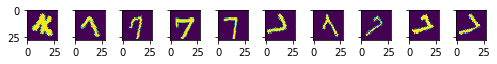

In [0]:
# Plotting random 10 samples from training dataset
import matplotlib.pyplot as plt 
rand_int = np.random.randint(0,100,size=10)
print(rand_int)
fig, axis = plt.subplots(1,10, 
                         figsize=(7,1),
                         sharex=True, sharey=True
                        )
j=0
for i in rand_int: 
    axis[j].imshow(hw4_tr7[i,:,:], aspect='auto') 
    j+=1    

plt.tight_layout()
plt.show()

In [0]:
tf.reset_default_graph()

In [0]:
# Pass batches of input  
X = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')

Y = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')

In [0]:
latent = 5

In [0]:
# using leaky-ReLU activation is used to ensure that the gradient flow through the backword pass even for the neurons where the value becomes zero, which is unlike ReLU.

def encoder(X): 
    activation = tf.nn.relu #(X,alpha=0.2) 
    
    with tf.variable_scope("encoder", reuse=None):
      
        X = tf.reshape(X, shape=[-1, 28, 28, 1])

        x_convl1 = tf.layers.conv2d(inputs=X, filters=64, kernel_size=4, strides=2, data_format='channels_last', padding='same', activation=activation)  
        print("x_convl1:", x_convl1.shape)

        x_convl2 = tf.layers.conv2d(x_convl1, filters=64, kernel_size=4, strides=2, data_format='channels_last', padding='same', activation=activation)
        print("x_convl2:", x_convl2.shape)
       
        x_convl3 = tf.layers.conv2d(x_convl2, filters=64, kernel_size=4, strides=1, data_format='channels_last', padding='same', activation=activation)
        print("x_convl3:", x_convl3.shape)
 

        #x_drop = tf.nn.dropout(x_convl3, 0.8)

        x = tf.contrib.layers.flatten(x_convl3)
        print("x:", x.shape)
             
        meAn = tf.layers.dense(x, units=latent)
        
        std = 0.5 * tf.layers.dense(x, units=latent)            
        
        ep = tf.random_normal(tf.stack([tf.shape(x)[0], latent])) 
        
        Z  = meAn + tf.multiply(ep, tf.exp(std))
        print("Z.shape:", Z.shape)
        
        return Z, meAn, std
      


In [0]:
dec_in_channels = 1
reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2

def decoder(dec_rec):
  
    activation = tf.nn.relu #leaky_relu(X,alpha=0.2)
    print("dec_rec.shape:", dec_rec.shape)
    with tf.variable_scope("decoder", reuse=None):
      
        x = tf.layers.dense(dec_rec, units=(49 * 1 / 2), activation=activation)
        print("x.shpe dec:", x.shape)
        
        x = tf.layers.dense(x, units=(49 * 1 / 2) * 2 , activation=activation)
        print("x1.shpe dec:", x.shape)
        
        x = tf.reshape(x, [-1, 7, 7, 1])
        
        x_convl1_dec = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, data_format='channels_last', padding='same', activation=activation)
        print("x_convl1_dec:", x_convl1_dec.shape)

        x_convl2_dec = tf.layers.conv2d_transpose(x_convl1_dec, filters=64, kernel_size=4, data_format='channels_last', strides=1, padding='same', activation=activation)
        print("x_convl2_dec:", x_convl2_dec.shape)
        
        x_convl3_dec = tf.layers.conv2d_transpose(x_convl2_dec, filters=64, kernel_size=4, data_format='channels_last', strides=1, padding='same', activation=activation)
        print("x_convl3_dec:", x_convl3_dec.shape)
        
        #x_drop = tf.nn.dropout(x_convl3_dec, 0.8)
        
        x = tf.contrib.layers.flatten(x_convl3_dec)
        
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        
        out = tf.reshape(x, shape=[-1, 28, 28])
        
        return out


In [0]:
data, meAn, std = encoder(X)
decode = decoder(data)

x_convl1: (?, 14, 14, 64)
x_convl2: (?, 7, 7, 64)
x_convl3: (?, 7, 7, 64)
x: (?, 3136)
Z.shape: (?, 5)
dec_rec.shape: (?, 5)
x.shpe dec: (?, 24)
x1.shpe dec: (?, 49)
x_convl1_dec: (?, 14, 14, 64)
x_convl2_dec: (?, 14, 14, 64)
x_convl3_dec: (?, 14, 14, 64)


In [0]:
print(decode.shape)

(?, 28, 28)


In [0]:
Decode_Reshaped = tf.reshape(decode, [-1, 28*28])
Y_Reshaped = tf.reshape(Y, shape=[-1, 28 * 28])


In [0]:
input_loss = tf.reduce_sum(tf.squared_difference(Decode_Reshaped, Y_Reshaped), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * std - tf.square(meAn) - tf.exp(2.0 * std), 1) # referred:  http://kvfrans.com/variational-autoencoders-explained/
loss = tf.reduce_mean(input_loss + latent_loss)


In [0]:
learning_rate= 0.001

optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(loss)


Instructions for updating:
Use tf.cast instead.


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [0]:


def next_batch(batch_size):
  batch=[]
  rand_integer = np.random.randint(0,hw4_tr7.shape[0],size=batch_size)
  #print("len(rand_integer):", len(rand_integer))
  for i in range(len(rand_integer)):
    batch.append(hw4_tr7[i])
  return np.array(batch)
  
#batch = next_batch(64)

#print(np.array(batch).shape) 

In [0]:
loss_lst = []
batch_size = 64
for i in range(5000):
    batch = next_batch(batch_size)
  #  print("batch.shape:", batch.shape)
    sess.run(optimizer, feed_dict = {X: batch, Y: batch})
    
    if (i % 20==0):
        los, d = sess.run([loss, decode], feed_dict = {X: batch, Y: batch })
        loss_lst.append(los)
        
        print("Iteration:", i, "Loss:", los)

Iteration: 0 Loss: 149.60791
Iteration: 20 Loss: 50.61859
Iteration: 40 Loss: 48.630924
Iteration: 60 Loss: 46.13833
Iteration: 80 Loss: 44.54473
Iteration: 100 Loss: 43.406654
Iteration: 120 Loss: 43.370163
Iteration: 140 Loss: 43.321854
Iteration: 160 Loss: 43.34198
Iteration: 180 Loss: 43.303368
Iteration: 200 Loss: 42.73204
Iteration: 220 Loss: 38.733227
Iteration: 240 Loss: 37.85589
Iteration: 260 Loss: 34.985893
Iteration: 280 Loss: 32.85949
Iteration: 300 Loss: 30.469547
Iteration: 320 Loss: 29.358442
Iteration: 340 Loss: 26.131657
Iteration: 360 Loss: 23.938778
Iteration: 380 Loss: 21.705654
Iteration: 400 Loss: 19.245113
Iteration: 420 Loss: 17.82924
Iteration: 440 Loss: 16.262459
Iteration: 460 Loss: 15.394963
Iteration: 480 Loss: 14.861111
Iteration: 500 Loss: 14.363522
Iteration: 520 Loss: 13.211176
Iteration: 540 Loss: 13.196253
Iteration: 560 Loss: 12.986528
Iteration: 580 Loss: 12.790789
Iteration: 600 Loss: 12.314348
Iteration: 620 Loss: 11.511137
Iteration: 640 Loss: 1

Text(0, 0.5, 'loss')

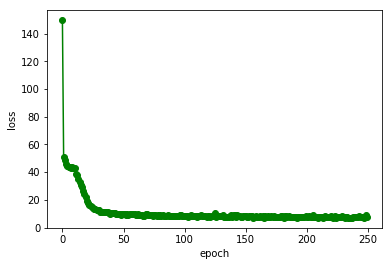

In [0]:
index = [i for i in  range(len(loss_lst))]

import matplotlib.pyplot as plt
plt.plot(index,loss_lst,'go-')
plt.xlabel('epoch')
plt.ylabel('loss')

In [0]:
# generating 10 random digit from the normal distribution
Num_of_samples = 20
randNumbers = [np.random.normal(0, 1, latent) for i in range(Num_of_samples)]


In [0]:
np.array(randNumbers).shape

(20, 5)

In [0]:
# test where will keep all the COlumns constant except one.

testrandNumbers= np.array(randNumbers)

In [0]:
testrandNumbers.shape

(20, 5)

In [0]:
import pandas as pd
df_testrandNumbers = pd.DataFrame(testrandNumbers)
df_testrandNumbers.head()

,0,1,2,3,4
0,-0.116323,0.958461,0.700771,0.440340,-0.999731
1,-0.037403,0.166319,-0.587893,0.333662,-1.740871
2,1.048013,1.560220,2.310055,-1.824623,0.015115
3,-1.300705,0.291376,-1.869883,-1.387482,0.603722
4,0.516097,-1.386167,1.263187,0.531601,0.817619


----------------------------------- K 0 -----------------------------------


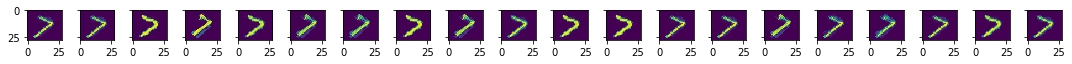

----------------------------------- K 1 -----------------------------------


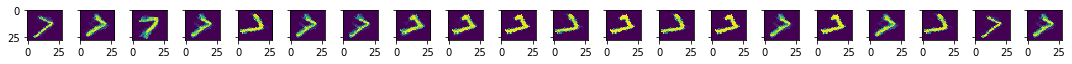

----------------------------------- K 2 -----------------------------------


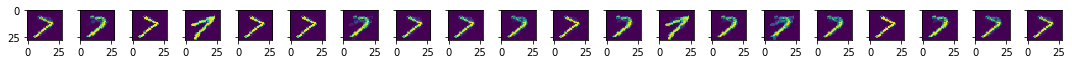

----------------------------------- K 3 -----------------------------------


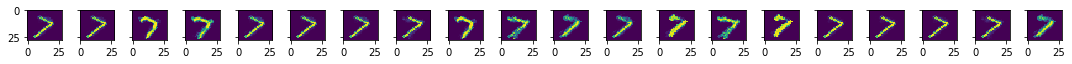

----------------------------------- K 4 -----------------------------------


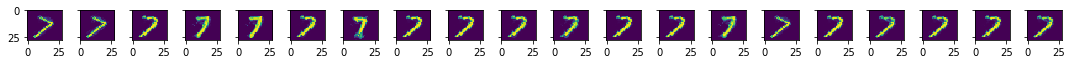

In [0]:

K_lst=list(range(latent))

for K in range(latent):
  K_final_lst = []
  K_column = df_testrandNumbers.loc[:,K]
 
  for i in K_lst:
    if (i!=K):
      K_final_lst.append(i)

  #print("K_final_lst:", K_final_lst)
  
  Remaining_set_of_columns = df_testrandNumbers.iloc[:,K_final_lst]
 # print(Remaining_set_of_columns.head(2))
  
  Remaining_set = pd.DataFrame(np.array([Remaining_set_of_columns.iloc[0],]*Num_of_samples),columns=Remaining_set_of_columns.columns)
  #print(Remaining_set.head(2))

  Remaining_set.insert(loc=K, column=K, value=K_column)

  Digits = sess.run(decode, feed_dict = {data: Remaining_set})
  
  digits= Digits
  
  print("----------------------------------- K", K, "-----------------------------------")
  
  fig, axis = plt.subplots(1,Num_of_samples, 
                         figsize=(15,1),
                         sharex=True, sharey=True
                        )
  j=0
  for digit in digits:
      axis[j].imshow(digit, aspect='auto') 
      j+=1    

  plt.tight_layout()
  plt.show()


In [0]:
# Based on the above result, with K=2 gets good output images.